In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import pandas as pd 
import numpy as np
import h5py
import sys
sys.path.append('/home/jma819/post_cmfe_analysis')
import python_utils_jjm as utils_jjm
import dlc_utils
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from scipy import stats

In [2]:
##wt files 
wt_sessions = ['GRIN039_H14_M8_S53','GRIN039_H12_M33_S29', 'GRIN039_H12_M26_S54', 'GRIN013_H13_M33_S54', 'GRIN027_H13_M29_S44', 'GRIN033_H14_M34_S32', 'GRIN033_H13_M42_S33',
 'GRIN032_H17_M30_S22', 'GRIN034_H15_M28_S2', 'GRIN026_H16_M35_S34', 'GRIN032_H16_M49_S22', 'GRIN034_H16_M13_S22', 'GRIN034_H19_M0_S18',
 'GRIN035_H13_M50_S58', 'GRIN035_H13_M31_S20', 'GRIN035_H14_M40_S34']

#ko files'GRIN038_H13_M37_S23'
ko_sessions = ['GRIN011_H10_M19_S59', 'GRIN041_H12_M54_S49', 'GRIN009_H13_M59_S14', 'GRIN038_H15_M39_S40', 'GRIN038_H11_M57_S0', 'GRIN038_H13_M37_S23',  
               'GRIN018_H17_M41_S43', 'GRIN018_H16_M13_S53', 'GRIN012_H17_M46_S35', 'GRIN012_H17_M32_S17', 'GRIN012_H16_M57_S23']

In [3]:
#need to get keys first from all session dataframes to read into pandas 
h5file=pd.HDFStore('/projects/b1118/miniscope/analysis/event_analysis/movement_regions_for_display_2.h5')
keys=h5file.keys()
h5file.close()

In [4]:
#keys

In [5]:
#load fluorescence in event regions
z_scored_events_by_session = {key_idx.strip('/'):pd.read_hdf('/projects/b1118/miniscope/analysis/event_analysis/movement_regions_for_display_2.h5', key=key_idx) for key_idx in keys}

In [15]:
#load velocity data 
velocity_data = pd.read_hdf('/projects/b1118/miniscope/analysis/event_analysis/compiled_velocity_all_sessions.h5')

In [7]:
#start_indicies=utils_jjm.return_list_of_level_indicies_in_session(z_scored_events_by_session['GRIN013_H13_M33_S54'].loc['z_scored_movement_regions'],0)
#stop_indicies=utils_jjm.return_list_of_level_indicies_in_session(z_scored_events_by_session['GRIN013_H13_M33_S54'].loc['z_scored_movement_regions'],1)

In [8]:
##to plot heatmap
# sort cells by peak latency for heatmap 
def return_cells_sorted_by_peak_latency(sessions_to_plot, z_scored_events_by_session, sample_bounds, z_score_threshold):
    # average each cells response across events within a session
    session_means_by_cell = pd.concat([z_scored_events_by_session[session].loc['z_scored_movement_regions'].unstack(level=[0, 1]).swaplevel(i=0, j=2, axis=1).iloc[sample_bounds[0]:sample_bounds[1]].mean(axis=1, level=2) 
                                   for session in sessions_to_plot], axis=1, keys=sessions_to_plot)
    # sort by average peak -- remove cells not surpassing z score criteria 
    session_means_by_cell = session_means_by_cell[[column for column in 
                                               (session_means_by_cell>z_score_threshold).any(0)[(session_means_by_cell>z_score_threshold).any(0)].index]]
    # flatten multi_level to tuple columns 
    session_means_by_cell.columns = list(session_means_by_cell.columns)
    #sort flattened columns by latency 
    sorted_by_latency = list(session_means_by_cell.idxmax(axis=0).sort_values().index)
    #new data frame sorted by latency 
    session_means_by_cell_sorted_by_latency=session_means_by_cell[sorted_by_latency]
    #range scale 
    scaler = MinMaxScaler()
    means_sorted_scaled = pd.DataFrame(scaler.fit_transform(session_means_by_cell_sorted_by_latency), 
                                       columns=session_means_by_cell_sorted_by_latency.columns)
    return(means_sorted_scaled)

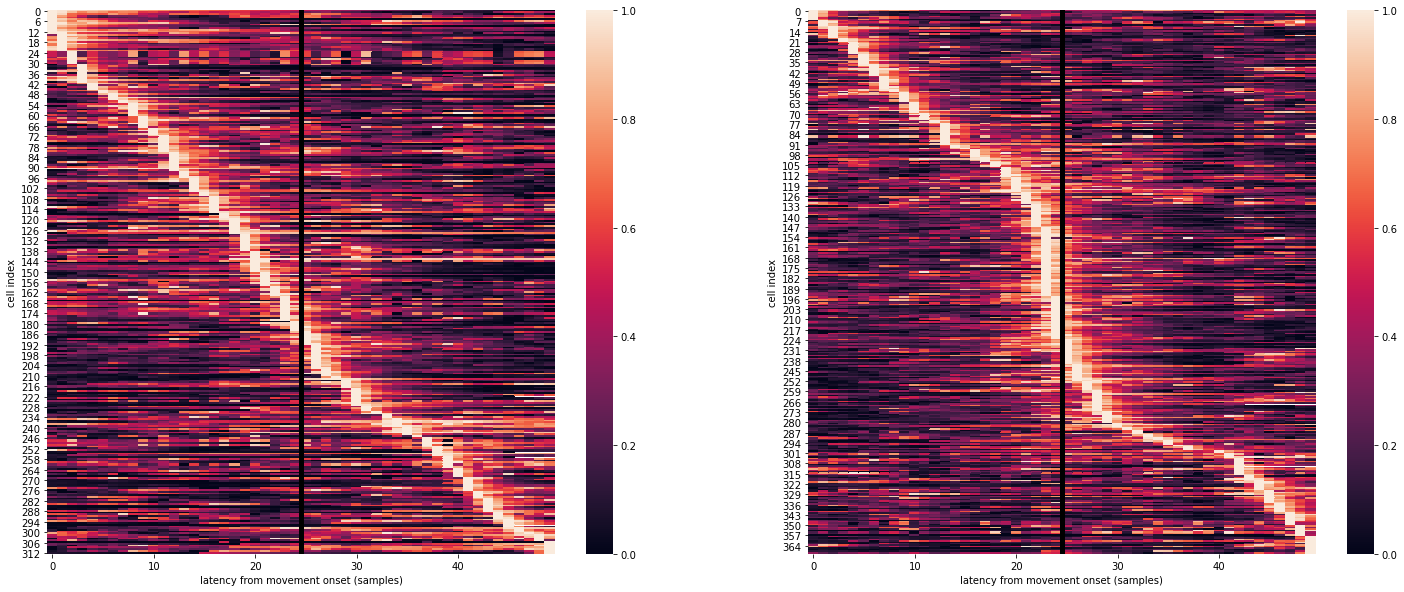

In [9]:
#wt sessions 
sample_bounds = (25, 75)
z_score_threshold = 2.5
wt_sessions_to_plot = [session for session in z_scored_events_by_session.keys() if session in wt_sessions]
means_sorted_scaled_wt = return_cells_sorted_by_peak_latency(wt_sessions_to_plot, z_scored_events_by_session, 
                                                             (sample_bounds[0],sample_bounds[1]), z_score_threshold)
#ko sessions 
ko_sessions_to_plot = [session for session in z_scored_events_by_session.keys() if session in ko_sessions]
means_sorted_scaled_ko = return_cells_sorted_by_peak_latency(ko_sessions_to_plot, z_scored_events_by_session, 
                                                             (sample_bounds[0],sample_bounds[1]), z_score_threshold)
fig = plt.figure()
fig.set_size_inches(25, 10)
p1 = fig.add_subplot(1,2,1)
ax = sns.heatmap(means_sorted_scaled_wt.transpose().reset_index(drop=True).iloc[:, 0:100], xticklabels=10)
ax.set_ylabel('cell index')
ax.set_xlabel('latency from movement onset (samples)')
ax.axvline(x=(25), linestyle='-', lw=5, color='k')
p2 = fig.add_subplot(1,2,2)
ax = sns.heatmap(means_sorted_scaled_ko.transpose().reset_index(drop=True).iloc[:, 0:100], xticklabels=10)
ax.set_ylabel('cell index')
ax.set_xlabel('latency from movement onset (samples)')
ax.axvline(x=(25), linestyle='-', lw=5, color='k')
#fig.savefig('/projects/b1118/miniscope/analysis/summaryfigures/latency_indiv_cells_sd25_outlierremoved.pdf', transparent=True)
plt.show()

In [11]:
# plot cumulative histogram
cumulative_latency = stats.cumfreq(means_sorted_scaled_wt.idxmax(axis=0).values, numbins=100, defaultreallimits=(0, 50))
cumulative_latency_ko = stats.cumfreq(means_sorted_scaled_ko.idxmax(axis=0).values, numbins=100, defaultreallimits=(0, 50))

cumulative_data = cumulative_latency.cumcount/len(means_sorted_scaled_wt.idxmax(axis=0).values)
cumulative_data_ko = cumulative_latency_ko.cumcount/len(means_sorted_scaled_ko.idxmax(axis=0).values)

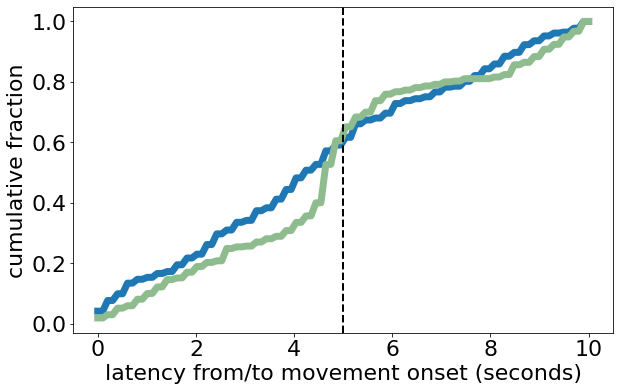

In [12]:
plt.rcParams.update({'font.size': 22})
plt.plot(np.linspace(0, 10, 100), cumulative_data, linewidth=7.0)
plt.plot(np.linspace(0, 10, 100), cumulative_data_ko, color='darkseagreen', linewidth=7.0)
#plt.xlim((-10, 10))
fig = plt.gcf()
fig.set_size_inches(10, 6)
ax = plt.gca()
ax.set_ylabel('cumulative fraction')
ax.set_xlabel('latency from/to movement onset (seconds)')
ax.axvline(x=(5), linestyle='--', lw=2, color='k')
fig.subplots_adjust(left=0.15)
#fig.savefig('/projects/b1118/miniscope/analysis/summaryfigures/latency_cumulative_fraction_sd25_outlierremoved.pdf', transparent=True)

In [13]:
##get the average peak latency by session
means_sorted_scaled_ko.columns = pd.MultiIndex.from_tuples(means_sorted_scaled_ko.columns)
means_sorted_scaled_wt.columns = pd.MultiIndex.from_tuples(means_sorted_scaled_wt.columns)

(-1.0, 3.0)

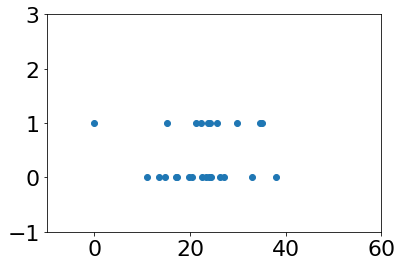

In [14]:
plt.scatter(np.concatenate((means_sorted_scaled_ko.idxmax(axis=0).mean(level=0).values, means_sorted_scaled_wt.idxmax(axis=0).mean(level=0).values)), 
            np.concatenate((np.ones(len(means_sorted_scaled_ko.idxmax(axis=0).mean(level=0).values)),
                            np.zeros(len(means_sorted_scaled_wt.idxmax(axis=0).mean(level=0).values)))))
plt.xlim((-10, 60))
plt.ylim((-1, 3))

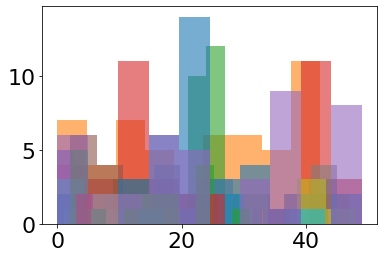

In [15]:
for session in list(means_sorted_scaled_wt.columns.levels[0]):
    plt.hist(means_sorted_scaled_wt[session].idxmax(axis=0), alpha=0.6)
plt.show()

In [16]:
means_sorted_scaled_wt.columns.levels[0]

Index(['GRIN013_H13_M33_S54', 'GRIN026_H16_M35_S34', 'GRIN027_H13_M29_S44',
       'GRIN032_H16_M49_S22', 'GRIN032_H17_M30_S22', 'GRIN033_H14_M34_S32',
       'GRIN034_H15_M28_S2', 'GRIN034_H16_M13_S22', 'GRIN034_H19_M0_S18',
       'GRIN035_H13_M31_S20', 'GRIN035_H13_M50_S58', 'GRIN035_H14_M40_S34',
       'GRIN039_H12_M26_S54', 'GRIN039_H12_M33_S29', 'GRIN039_H14_M8_S53'],
      dtype='object')

In [17]:
means_sorted_scaled_ko.columns.levels[0]

Index(['GRIN009_H13_M59_S14', 'GRIN011_H10_M19_S59', 'GRIN012_H16_M57_S23',
       'GRIN012_H17_M32_S17', 'GRIN012_H17_M46_S35', 'GRIN018_H17_M41_S43',
       'GRIN038_H11_M57_S0', 'GRIN038_H13_M37_S23', 'GRIN038_H15_M39_S40',
       'GRIN041_H12_M54_S49'],
      dtype='object')

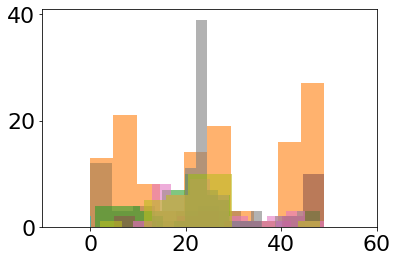

In [20]:
for session in list(means_sorted_scaled_ko.columns.levels[0]):
    plt.hist(means_sorted_scaled_ko[session].idxmax(axis=0), alpha=0.6)
plt.xlim((-10, 60))
plt.show()

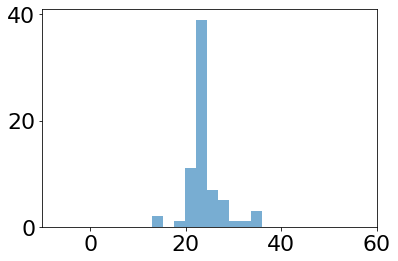

In [23]:
#plt.hist(means_sorted_scaled_ko['GRIN038_H13_M37_S23'].idxmax(axis=0), alpha=0.6)
plt.hist(means_sorted_scaled_ko['GRIN038_H13_M37_S23'].idxmax(axis=0), alpha=0.6)
plt.xlim((-10, 60))
plt.show()

In [28]:
means_sorted_scaled_ko['GRIN038_H13_M37_S23'].loc[means_sorted_scaled_ko['GRIN038_H13_M37_S23'].idxmax(axis=0)>20]

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [36]:
#cells clustered around mean
means_sorted_scaled_ko['GRIN038_H13_M37_S23'].idxmax(axis=0)[(means_sorted_scaled_ko['GRIN038_H13_M37_S23'].idxmax(axis=0)>20) & 
                                                            (means_sorted_scaled_ko['GRIN038_H13_M37_S23'].idxmax(axis=0)<30)].index

Int64Index([ 39,  74, 149,  10,  14,  52, 238,  54, 264, 270,  16,  97,   4,
             29,  77,  45,  98,   6,  43,   8,   9,  47, 120, 106, 251, 226,
            225, 166,   3, 109, 118, 122,  33, 124, 162, 123,  15,  26,  94,
             42, 117,  75,  72,  71,  62,  61,  60,  58,  48, 170, 103, 127,
            107,  41,  99,  59,  34, 100,  84, 110, 113, 129],
           dtype='int64')